# 2. 없다면 어떻게 될까? (ResNet Ablation Study)

# 2-1. 들어가며

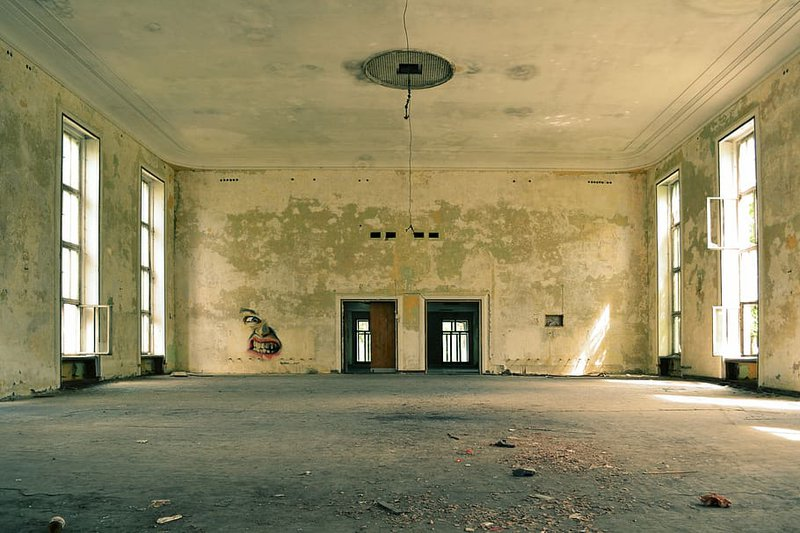

<br>

딥러닝 논문에서는 다양한 방법들을 적용하며, 그 방법 적용 전후의 차이를 실험 결과로 보여줍니다. 이때 논문에는 어느 정도 구현 방법과 실험의 설정이 나와있으니, 하드웨어 자원을 엄청나게 필요로 하거나 특정한 데이터셋이 필요한 경우를 제외하면 어느 정도 따라해볼 수 있는데요. 평소 논문을 보고 이해하는 데 집중하셨다면, 이번 시간에는 모델을 구현하고, 모델에 각 기법을 적용했을 때와 아닐 때를 비교해 보면서 효과를 직접 체감해보는 시간을 갖도록 하겠습니다.

<br>

### 실습목표

---

- 직접 ResNet 구현하기
- 모델을 config에 따라서 변경 가능하도록 만들기
- 직접 실험해서 성능 비교하기

<br>

### 학습내용

---

1. Ablation Study
2. CIFAR-10 데이터셋 준비
3. 블록 구성
4. VGG Complete Model
5. VGG-16 vs VGG-19
6. ResNet Ablation Study

# 2-2. Ablation Study

저희가 지금부터 해볼 프로젝트는 **애블레이션연구(ablation study)** 입니다. 직역하자면 '제거 연구'정도가 되겠네요.

<br>

딥러닝 논문은 여러 가지 방법들을 결합해서 어떤 문제를 해결하는 방법을 제시합니다. 이때 제안한 방법들의 유효함을 증명하기 위해서 보통 딥러닝 논문에서는 해당 방법을 "제거"한 모델로 수행한 실험과, 해당 방법을 추가한 모델로 수행한 실험의 결과를 비교합니다. 애블레이션 연구란 이처럼 "아이디어를 제거해 봄으로써" 제안한 방법이 어떻게 성능이나 문제에 해결에 효과를 주는지 확인하는 실험입니다.

<br>

아래는 ResNet 논문에서 제시한 residual connection의 애블레이션 연구입니다. 이미지넷(ImageNet) 검증 데이터셋(validation dataset)에 대한 Top-1 error rate을 지표로 사용해 residual connection이 없는 일반 네트워크(plain net)와 ResNet을 비교하였습니다. 이 비교를 통해서 ResNet이 residual connection을 활용해서 깊은 네트워크를 쌓았을 때, 이를 통한 성능 향상을 얻을 수 있음을 증명하고 있습니다.

<br>

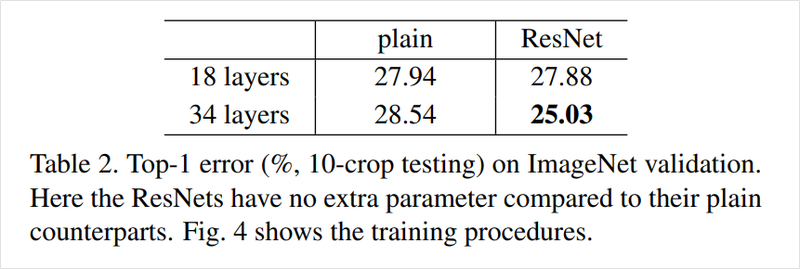

# 2-3. Ablation Study 실습 (1) CIFAR-10 데이터셋 준비하기

**ResNet**이 막 공개된 시점으로 돌아갔다고 생각해 봅시다. 우리는 이 방법이 논문으로는 유효하다고 들었지만 직접 실험을 해 성능을 평가하고, 다른 실험에 적용해 보기로 합니다.

<br>

ResNet의 성능을 평가하기 위해서 원래 논문과 동일한 이미지넷의 훈련/검증 데이터셋을 사용해 학습과 평가를 진행하면 좋겠지만, 우리는 컴퓨팅 자원이 부족하므로 이미지넷보다는 적당한 크기의 CIFAR-10 데이터셋으로 평가해보도록 합시다.

<br>

지금부터 우리의 실험은 **CIFAR-10에 대해 일반 네트워크와 ResNet을 구현해서 이 둘을 비교하여 ResNet 및 residual connection의 유효성을 확인하는 것**입니다. ResNet에 대한 설명은 ResNet 이론 자료를 다시 한번 확인하도록 합시다.

* [Deep residual learning for image recognition](https://openaccess.thecvf.com/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf).

## 1) CIFAR-10

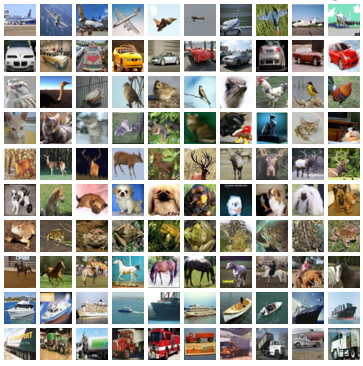

* [CIFAR-10 from Tensorflow dataset](https://www.tensorflow.org/datasets/catalog/cifar10)

<br>

그럼 우리가 이번에 모델을 사용해서 풀어야 할 문제가 무엇인지 확인해보도록 합시다. CIFAR-10 데이터셋은 10개 카테고리에 대해 총 6만 장의 이미지가 있습니다. 각 이미지들의 가로, 세로는 각각 32 픽셀(pixel)입니다. MNIST에서 손글씨가 나타내는 숫자를 분류해내었던 것처럼 CIFAR-10 데이터셋을 사용해 물체의 종류를 분류해보도록 하겠습니다.

In [ ]:
# 데이터셋을 준비
# 만약 텐서플로우에서 제공하는 tensorflow-datasets 패키지가 설치되어 있지 않다면 아래 명령어로 설치
#pip install tensorflow-datasets

In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [ ]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incomplete55UBNN/cifar10-train.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incomplete55UBNN/cifar10-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [ ]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})


In [ ]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(50000, shape=(), dtype=int64)
tf.Tensor(10000, shape=(), dtype=int64)


Tensorflow의 데이터셋은 Numpy가 아니므로 ds_train.shape 같은 게 존재하지 않습니다. 위와 같은 방법으로 데이터셋의 이미지 shape와 전체 데이터의 개수, 라벨 클래스의 개수 등 가장 중요한 정보들이 잘 확인되었나요?

In [ ]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    # image = tf.image.resize(image, [32, 32])
    return tf.cast(image, tf.float32) / 255., label

In [ ]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

MNIST 데이터셋 클래스는 0부터 9까지의 숫자, 총 10가지가 있습니다. CIFAR-10 데이터셋 또한 이름에서 알 수 있듯이 10개 클래스를 가집니다. 아래 코드로 각 클래스가 어떻게 구성되는지, 어떤 이미지가 있는지 확인해 보세요!

## 2) Input Normalization

**Data Normalization** 은 데이터의 범위를 사용자가 원하는 범위로 제한하는 것입니다. 이미지 데이터의 경우 픽셀 정보를 0~255 사이의 값으로 가지는데, 이를 255로 나누어주면 0 ~ 1.0 사이의 값을 가지게 될 거예요. 위의 예를 수식으로 간단하게 쓴다면, (정규화하고자 하는 값 - 데이터 값들 중 최소값) / (데이터 값들 중 최대값 - 데이터 값들 중 최소값) 이죠.

$$\frac{x−x_{min}}{x_{max}−x_{min}}$$
​

Data Normalization을 하는 이유는 머신러닝에서 scale이 큰 feature의 영향이 비대해지는 것을 방지하고, 딥러닝에서 Local optimum에 빠질 위험을 줄이는(학습 속도 향상) 거예요.

<br>

아래 그림을 보면 왼쪽이 정규화 하지 않은 경우의 Cost function 이고 오른쪽이 정규화 한 Cost function 일 때, 정규화 한 경우가 Local optimum 에서 더 빨리 빠져나올 수 있다는 것을 직관적으로 이해할 수 있습니다.그리고 scikit-learn에서 MinMaxScaler로 쉽게 사용 할 수 있어요.

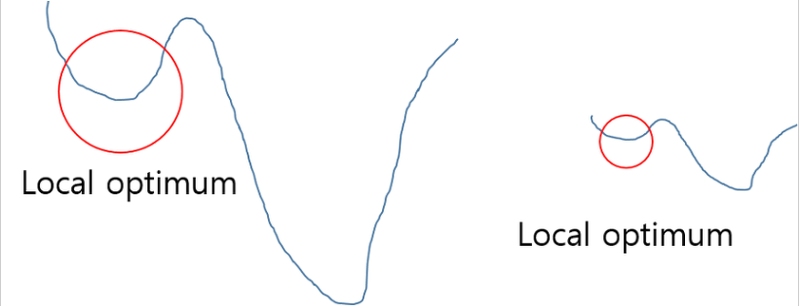

<br>

우리는 "가로 1920, 세로 1080 픽셀의 이미지"처럼 픽셀의 수를 사용해 이미지의 크기를 말할 수 있는데요. 이때 한 픽셀이 가진 채널(channel) 값은 픽셀의 색을 표현합니다. RGB는 Red, Green, Blue로 세 가지 색을 조합해서 우리가 보는 다양한 색을 만들어내는 방법이죠. 그레이 스케일(gray scale)은 단순하게 흑과 백만을 표현하는 하나의 채널을 가진 이미지입니다. RGB나 그레이 스케일 외에도 HSV, CMYK 등 인쇄 또는 이미지 작업을 위해 사용되는 다양한 채널 체계가 있습니다.

<br>

우리의 모델에 넣어주기 전에는 각 채널별 최댓값인 255로 **정규화(normalize)**를 해주어 이미지의 표현이 0과 1 사이로 들어오도록 만들어줍니다.

In [ ]:
ds_info.features["label"].num_classes

10

In [ ]:
ds_info.features["label"].names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

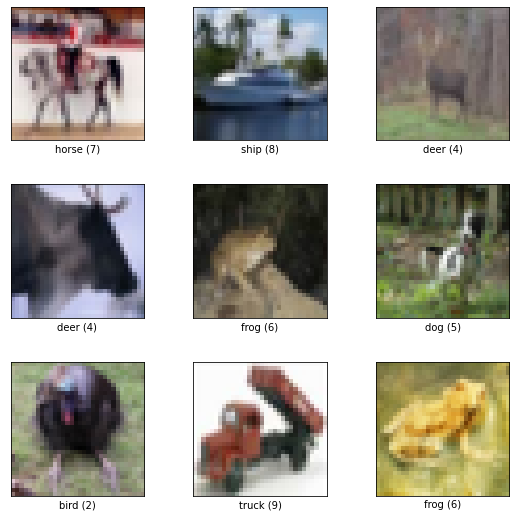

In [ ]:
fig = tfds.show_examples(ds_train, ds_info)

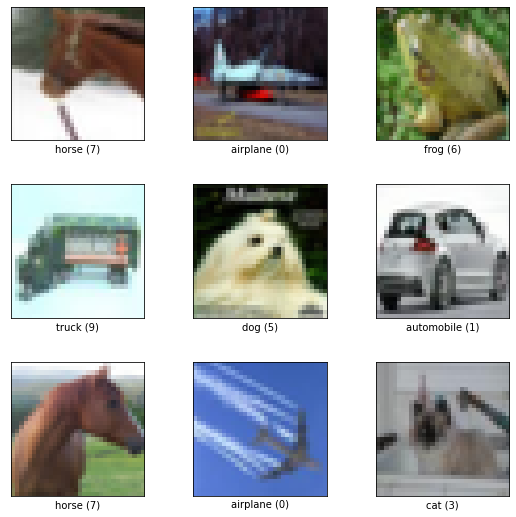

In [ ]:
fig = tfds.show_examples(ds_test, ds_info)

모델의 학습을 위한 데이터셋에 대한 확인은 충분히 한 것 같습니다. 이제 본격적으로 코딩을 하면서 모델을 직접 빌딩하는 시간을 갖도록 하겠습니다.

# 2-4. Ablation Study 실습 (2) 블록 구성하기

모델을 프로그램으로 구현하는 과정에서는 논문의 모델을 그대로 구현하는 것도 중요하지만, 구현 시에 반복되는 부분을 줄여서 하이퍼파라미터 또는 변수를 변경하거나 모델 구조가 변경될 때 손쉽게 바꿀 수 있도록 만들어 놓는 것이 필요합니다.

<br>

최근 나오는 일반적인 딥러닝 모델에서 이렇게 주요 구조를 모듈화 시켜 조금씩 바꾸어 쓸 수 있는 단위를 **블록(block)** 이라고 부릅니다. **레이어(layer)** 는 기본적으로 텐서플로우(TensorFlow), 케라스(Keras), 파이토치(PyTorch) 등에서 기본적으로 제공하는 단위입니다. 우리는 여기서 한 단계 위인 "블록"을 단위로 모델을 만들 수 있어야 합니다.

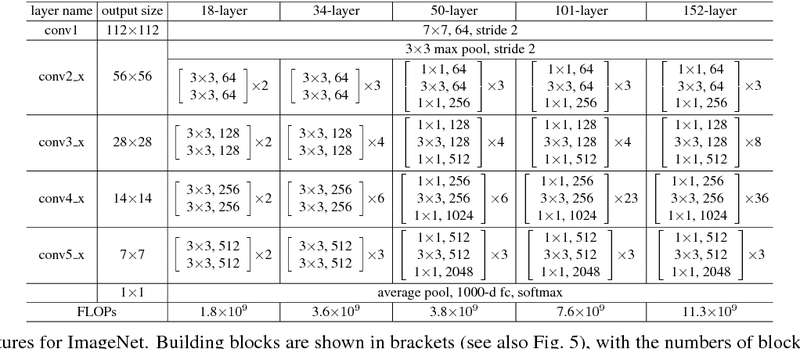

<br>

프로젝트로 구현할 **ResNet**을 보면 ResNet-18, 34, 50, 101, 152로 다섯 가지 네트워크가 있습니다. 각 네트워크를 하나씩 구현하는 방법도 있지만 매우 수고스럽고 변경사항이 생기면 모두 고쳐줘야 하는 불편함이 생기게 됩니다. 따라서 이후 실습에서 우리는 ResNet의 기본 구조인 블록을 먼저 구현하겠습니다.

> ResNet을 바로 구현하는 것은 어려울 수 있으므로, 지금부터 조금 더 간단한 블록이 반복되는 VGG를 예시로 구현해 보겠습니다.

## VGG 기본 블록 만들기

---

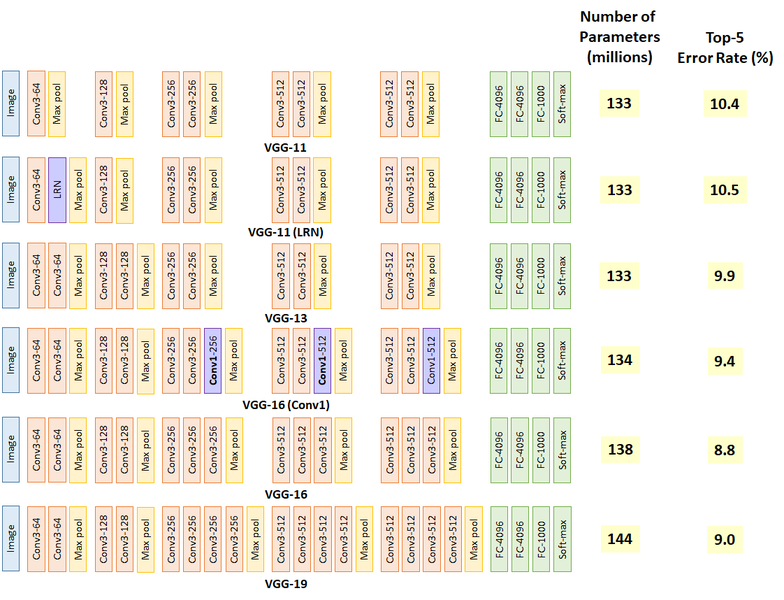

<br>

VGG는 여러 가지 버전이 있습니다. 이 중 VGG의 VGG-16과 VGG-19의 기본 구조가 되는 블록을 만든다고 가정하고 블록을 구현해 봅시다.

<br>

블록을 구현하기 위해 모델 구조의 특징을 짚어보겠습니다. VGG의 블록은 개략적으로 CNN 레이어 여러 개와 Max pooling 레이어 한 개로 이루어집니다. CNN은 모두 커널 크기가 3x3 라는 대표적인 특징을 가지고 있습니다. 그리고 블록 내 CNN 레이어의 채널은 하나로 유지되지만 서로 다른 블록 간 CNN 레이어의 채널 수는 다를 수 있습니다. 블록에 따라서 CNN 레이어의 개수 또한 달라집니다. 블록의 마지막에는 항상 Max Pooling 레이어가 붙습니다. 따라서 우리의 블록은 CNN 레이어 여러 개와 Max pooling 레이어 한 개로 이루어질 것이고, CNN의 레이어 수와 채널을 조절할 수 있어야 합니다.

<br>

`block_num`은 레이어의 이름을 붙여주기 위해서 추가되었고 `input_shape`는 summary를 출력하기 위해서 넣어주었습니다.

In [ ]:
# function for building VGG Block

def build_vgg_block(input_layer,
                    num_cnn=3, 
                    channel=64,
                    block_num=1,
                   ):
    # 입력 레이어
    x = input_layer

    # CNN 레이어
    for cnn_num in range(num_cnn):
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3,3),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv{cnn_num}'
        )(x)    

    # Max Pooling 레이어
    x = keras.layers.MaxPooling2D(
        pool_size=(2, 2),
        strides=2,
        name=f'block{block_num}_pooling'
    )(x)

    return x

이제 위에서 만든 VGG 블록을 추가하는 함수를 이용해서 `input_layer` 에 추가를 해 봅시다. 입력 레이어는 아까 데이터셋에서 확인한 32, 32의 가로 세로 크기를 가지고 채널로 3을 가지므로 `(32,32,3)` 이 됩니다. 이 입력 레이어를 인자로 받아 `build_vgg_block()` 는 블록의 레이어를 build하고 출력값을 얻을 수 있습니다. 이제 케라스의 `Model` 클래스에서 `input`과 `output`을 정의해 주면 간단히 블록의 모델을 확인해볼 수 있습니다.

* [tf.keras.Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model)

In [ ]:
vgg_input_layer = keras.layers.Input(shape=(32,32,3))   # 입력 레이어 생성
vgg_block_output = build_vgg_block(vgg_input_layer)    # VGG 블록 생성

In [ ]:
# 블록 1개짜리 model 생성
model = keras.Model(inputs=vgg_input_layer, outputs=vgg_block_output)  

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv0 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pooling (MaxPooling2  (None, 16, 16, 64)       0         
 D)                                                              
                                                                 
Total params: 75,648
Trainable params: 75,648
Non-trainable params: 0
_________________________________________________________

# 2-5. Ablation Study 실습 (3) VGG Complete Model

이제 기본적인 블록을 만들 수 있는 함수를 만들었으니 이를 합쳐서 전체 모델을 만들 수 있는 함수를 만들어보겠습니다.

## 1) VGG-16

먼저 작은 네트워크인 VGG-16을 먼저 만들어 보겠습니다. 블록 내의 CNN 레이어 수와 채널 수는 블록마다 달라집니다. 이는 VGG-16과 VGG-19에 따라서 같이 변화되므로 함수에 전달되어야 합니다. 여기서는 각 블록 별 CNN의 수와 채널을 리스트로 전달했습니다.

In [ ]:
# VGG 모델 자체를 생성하는 함수입니다.
def build_vgg(input_shape=(32,32,3),
              num_cnn_list=[2,2,3,3,3],
              channel_list=[64,128,256,512,512],
              num_classes=10):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer
    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_vgg_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i
        )
        
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc1')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc2')(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

In [ ]:
# 기본값을 그대로 사용해서 VGG 모델을 만들면 VGG-16이 됩니다.
vgg_16 = build_vgg()

vgg_16.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block0_conv0 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block0_conv1 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block0_pooling (MaxPooling2  (None, 16, 16, 64)       0         
 D)                                                              
                                                                 
 block1_conv0 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block1_conv1 (Conv2D)       (None, 16, 16, 128)       147584    
                                                           

## 2) VGG-19

위에서 16을 만들어봤으니 쉽게 구성(configuration)을 바꿔서 VGG-19를 만들 수 있습니다.

In [ ]:
# 원하는 블록의 설계에 따라 매개변수로 리스트를 전달해 줍니다.
vgg_19 = build_vgg(
    num_cnn_list=[2,2,4,4,4],
    channel_list=[64,128,256,512,512]
)

vgg_19.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block0_conv0 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block0_conv1 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block0_pooling (MaxPooling2  (None, 16, 16, 64)       0         
 D)                                                              
                                                                 
 block1_conv0 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block1_conv1 (Conv2D)       (None, 16, 16, 128)       147584    
                                                           

# 2-6. Ablation Study 실습 (4) VGG-16 vs VGG-19

이제 본격적으로 위에서 준비한 데이터셋과 모델의 성능 비교를 위해서 모델을 훈련하고 평가하겠습니다.

VGG는 레이어의 차이를 위해서 **VGG-16**과 **VGG-19**를 비교해보도록 하겠습니다.

우선 CIFAR-10 데이터셋을 불러옵시다.

In [ ]:
BATCH_SIZE = 256
EPOCH = 15

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

VGG-16 모델을 만들고 훈련시켜 줍니다.

> ❗잠깐

> 이 작업은 시간이 상당히 소요됩니다. BATCH_SIZE가 커지면 소요시간이 좀 줄어드는 효과가 있습니다만, 1epoch당 1분 이상 소요될 수도 있습니다. 이 훈련은 40Epoch 정도 수행하는 것을 권장하지만, 15Epoch 정도로도 어느 정도 근접하는 성능을 얻을 수는 있을 것입니다.

In [ ]:
vgg_16.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_16 = vgg_16.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


195/195 [==============================] - 33s 86ms/step - loss: 2.1929 - accuracy: 0.1812 - val_loss: 2.0636 - val_accuracy: 0.2651
Epoch 2/15
195/195 [==============================] - 15s 76ms/step - loss: 2.0111 - accuracy: 0.2691 - val_loss: 1.9553 - val_accuracy: 0.2896
Epoch 3/15
195/195 [==============================] - 15s 76ms/step - loss: 1.8765 - accuracy: 0.3253 - val_loss: 1.8176 - val_accuracy: 0.3374
Epoch 4/15
195/195 [==============================] - 15s 76ms/step - loss: 1.7599 - accuracy: 0.3693 - val_loss: 1.7007 - val_accuracy: 0.3948
Epoch 5/15
195/195 [==============================] - 15s 75ms/step - loss: 1.6743 - accuracy: 0.3981 - val_loss: 1.6482 - val_accuracy: 0.4146
Epoch 6/15
195/195 [==============================] - 15s 76ms/step - loss: 1.6030 - accuracy: 0.4247 - val_loss: 1.5893 - val_accuracy: 0.4360
Epoch 7/15
195/195 [==============================] - 15s 76ms/step - loss: 1.5508 - accuracy: 0.4429 - val_loss: 1.5569 - val_accuracy: 0.4337
Epo

VGG-19 모델을 만들고 훈련시켜 줍니다.

> 파라미터가 더 많은 VGG-19는 VGG-16보다 1/4 정도 훈련 시간이 더 걸립니다. Epoch 수나 BATCH_SIZE를 잘 조절해 주세요.

In [ ]:
vgg_19.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_19 = vgg_19.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


195/195 [==============================] - 21s 89ms/step - loss: 2.2281 - accuracy: 0.1615 - val_loss: 2.1218 - val_accuracy: 0.1963
Epoch 2/15
195/195 [==============================] - 17s 88ms/step - loss: 2.0359 - accuracy: 0.2559 - val_loss: 1.9424 - val_accuracy: 0.3071
Epoch 3/15
195/195 [==============================] - 17s 89ms/step - loss: 1.8890 - accuracy: 0.3143 - val_loss: 1.8421 - val_accuracy: 0.3354
Epoch 4/15
195/195 [==============================] - 17s 88ms/step - loss: 1.7723 - accuracy: 0.3576 - val_loss: 1.6966 - val_accuracy: 0.3941
Epoch 5/15
195/195 [==============================] - 17s 88ms/step - loss: 1.6822 - accuracy: 0.3869 - val_loss: 1.6129 - val_accuracy: 0.4176
Epoch 6/15
195/195 [==============================] - 17s 88ms/step - loss: 1.6098 - accuracy: 0.4154 - val_loss: 1.5747 - val_accuracy: 0.4408
Epoch 7/15
195/195 [==============================] - 17s 88ms/step - loss: 1.5605 - accuracy: 0.4344 - val_loss: 1.5709 - val_accuracy: 0.4267
Epo

이제 VGG-16과 VGG-19를 그래프를 그리고 비교해보도록 하겠습니다. 먼저 훈련 손실(training loss)이 어떻게 다르게 진행되는지 비교해봅시다.

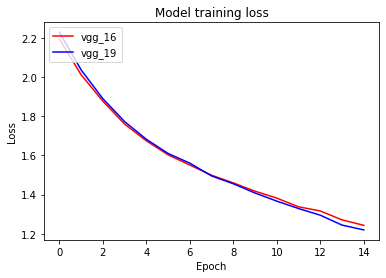

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history_16.history['loss'], 'r')
plt.plot(history_19.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()

그리고 검증 정확도(validation accuracy)를 비교해 봅시다.

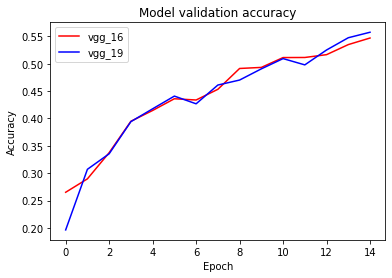

In [ ]:
plt.plot(history_16.history['val_accuracy'], 'r')
plt.plot(history_19.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()

# 2-7. 프로젝트: ResNet Ablation Study